# Pacman


### Enviroment:
The enviroment consists of 7 in 9 cells. Each cell contains either food, wall or is empty. Agent is placed in first row and first column. The task in find the best policy for agent to collect all foods with minimum hitting to walls.
### Rewards:
Wall cell has -2 reward, foods has +1 reward and empty cell has -1 reward.

### Import packages

In [ ]:

import pygame
from pygame.locals import *
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

### Define Enviroment and Game Functions:
In Env class, all the game data, such as rewards, position of walls, position of foods, position of agent, Q-table, rules of game, training and testing agent is done.

In [6]:
class Env:
  """
  Initialization of map, gamma, alpha, epsilon and Q-table is done in init function.
  """
  def __init__(self, row, col, gamma, alpha, epsilon = 0.9):
    self.col = col
    self.row = row
    self.reward = np.ones((row, col))
    self.reward[0, 0] = 0
    self.Q = np.zeros((4, 2 * 4**8))
    self.gamma = gamma
    self.alpha = alpha
    self.epsilon = epsilon
    self.current_row = 0
    self.current_col = 0
    self.food = row * col
    self.curr_food = 0
    self.current_reward = 0
    self.iterations = []

  """
  Use this function to reset map to its initialized status for new episod.
  """
  def reset_map(self):
    self.reward = np.ones((self.row, self.col))
    self.reward[0, 0] = 0
    self.add_wall(self.wall_pos, True)

  """
  Use this to add wall to map.
  """
  def add_wall(self, positions, update = False, reward = -2):
    self.wall_pos = positions
    self.reward[positions[:, 0], positions[:, 1]] = reward
    if not update:
      self.food -= (positions.shape[0] + 1)

  """
  This function returns the state of agent based on current status of map and its position in the map.
  """
  def state(self, row, col):#0->boundary, 1->food, 2->empty, 3->wall
    d_r = u_r = u_l = d_l = down = right = up = left = 0
    if row != self.row-1:
      if self.reward[row+1, col] == 1: down = 1
      elif self.reward[row+1, col] == 0: down = 2
      else: down = 3
    if col != self.col-1:
      if self.reward[row, col+1] == 1: right = 1
      elif self.reward[row, col+1] == 0: right = 2
      else: right = 3
    if row != 0:
      if self.reward[row-1, col] == 1: up = 1
      elif self.reward[row-1, col] == 0: up = 2
      else: up = 3
    if col != 0:
      if self.reward[row, col-1] == 1: left = 1
      elif self.reward[row, col-1] == 0: left = 2
      else: left = 3
    if down != 0 and right != 0:
      if self.reward[row+1, col+1] == 1: d_r = 1
      elif self.reward[row+1, col+1] == 0: d_r = 2
      else: d_r = 3
    if up != 0 and right != 0:
      if self.reward[row-1, col+1] == 1: u_r = 1
      elif self.reward[row-1, col+1] == 0: u_r = 2
      else: u_r = 3
    if up != 0 and left != 0:
      if self.reward[row-1, col-1] == 1: u_l = 1
      elif self.reward[row-1, col-1] == 0: u_l = 2
      else: u_l = 3
    if down != 0 and left != 0:
      if self.reward[row+1, col-1] == 1: d_l = 1
      elif self.reward[row+1, col-1] == 0: d_l = 2
      else: d_l = 3
    return (4**7*down + 4**6*right + up * 4**5 + left * 4**4 + d_r * 4**3 + u_r * 4 ** 2 + u_l * 4 + d_l)

  """
  Check if what actions are invalid in particular state.
  """
  def check_move(self):
    for j in range(self.Q.shape[1]):
      res = self.check_state(j)
      for i in range(4):
        if res[i] == 0:
          self.Q[i, j] = -np.inf

  """
  Map state number to a quaternary number with length 8 to observe what is around agent.
  """
  def check_state(self, state):
    num = state
    res = [0, 0, 0, 0, 0, 0, 0, 0]
    i = 0
    while num > 0:
      res[7 - i] = num % 4
      i += 1
      num //= 4
    return res
  
  """
  Return reward based on the current action and state.
  """
  def action_reward(self, state, action):
    res = self.check_state(state)
    if action == 0:
      if res[action] == 1:
        self.current_row += 1
        self.curr_food += 1
        self.reward[self.current_row, self.current_col] = 0
        return 2
      elif res[action] == 2:
        self.current_row += 1
        return -1
      elif res[action] == 3:
        return -2

    elif action == 1:
      if res[action] == 1:
        self.current_col += 1
        self.curr_food += 1
        self.reward[self.current_row, self.current_col] = 0
        return 2
      elif res[action] == 2:
        self.current_col += 1
        return -1
      elif res[action] == 3:
        return -2

    elif action == 2:
      if res[action] == 1:
        self.current_row -= 1
        self.curr_food += 1
        self.reward[self.current_row, self.current_col] = 0
        return 2
      elif res[action] == 2:
        self.current_row -= 1
        return -1
      elif res[action]== 3:
        return -2

    elif action == 3:
      if res[action] == 1:
        self.current_col -= 1
        self.curr_food += 1
        self.reward[self.current_row, self.current_col] = 0
        return 2
      elif res[action] == 2:
        self.current_col -= 1
        return -1
      elif res[action] == 3:
        return -2

  """
  Move agent from current state to a random state or base state, depends on epsilon value.
  """
  def move(self, state):
    actions = self.Q[:, state]
    action = 0
    if np.random.random() < self.epsilon:
      while True:
        action = np.random.randint(0, 4)
        if actions[action] != -np.inf:
          break
    else:
      action = np.where(actions == max(actions))[0][0]
    reward = self.action_reward(state, action)
    self.current_reward += reward
    next_state = self.state(self.current_row, self.current_col)
    self.Q[action, state] += self.alpha * (reward + self.gamma * max(self.Q[:, next_state]) - self.Q[action, state])

  """
  Use this to do a compelete episod.
  """
  def episod(self):
    self.current_row = 0
    self.current_col = 0
    iteration = 0
    while self.curr_food < self.food:
      state = self.state(self.current_row, self.current_col)
      self.move(state)
      iteration += 1
      if iteration > 5000:
        break
      #if iteration > self.row * self.col:
        #self.epsilon = 0.1
    return iteration

  """
  Use this to train the Agent, in a certain number of episods.
  """
  def game(self):
    i = 0
    c = 1.05
    self.check_move()
    n_games = 80
    while i < n_games:
      #print('ep', i, ':', self.epsilon)
      self.reset_map()
      self.epsilon =  self.epsilon / c**i
      self.iterations.append(self.episod())
      self.current_reward = 0
      self.curr_food = 0
      i += 1
    ax = sns.lineplot(self.iterations)
    ax.set(xlabel='Episod', ylabel='Iterations')
    ax.set_title("Number of iterations to halt in each episod")

  """
  Use this function to visualy test pacman in trained model
  """
  def test_game(self):
    pygame.init()
    # Set up the display
    cell_size = 100  # Size of each cell in pixels
    map_width = self.col  # Number of cells in the horizontal direction
    map_height = self.row # Number of cells in the vertical direction
    screen_width = cell_size * map_width
    screen_height = cell_size * map_height
    screen = pygame.display.set_mode((screen_width, screen_height))
    pygame.display.set_caption("Pacman")
    # Define colors
    WHITE = (255, 255, 255)
    BLACK = (0, 0, 0)
    BLUE = (0, 0, 255)
    self.reset_map()
    self.current_reward = 0
    self.curr_food = 0
    self.current_row = 0
    self.current_col = 0
    last_x = last_y = 0
    self.epsilon = 0.05
    iterate_last_food = last_food = 0
    while self.curr_food < self.food:
        state = self.state(self.current_row, self.current_col)
        self.move(state)
        pacman_map = self.reward
        screen.fill(BLACK)
        # Render the map
        running = True
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        if not running:
            break
        for x in range(map_height):
            for y in range(map_width):
                cell_color = WHITE
                if pacman_map[x][y] == -2:
                    cell_color = BLACK
                if pacman_map[x][y] == 1:
                    cell_color = BLUE
                rectangle = pygame.Rect(y * cell_size, x * cell_size, cell_size, cell_size)
                    #cell_color = YELLOW
                pygame.draw.rect(screen, cell_color, rectangle)
                if x == self.current_row and y == self.current_col:
                    if last_x > self.current_row:
                        image = pygame.image.load("up_pac.png")  # Replace "image.jpg" with the path to your image file
                    elif last_x < self.current_row:
                        image = pygame.image.load("bottom_pac.png") 
                    elif last_y < self.current_col:
                        image = pygame.image.load("right_pac.png") 
                    elif last_y > self.current_col:
                        image = pygame.image.load("left_pac.png") 
                    else:
                        image = pygame.image.load("right_pac.png")
                    image = pygame.transform.scale(image, (cell_size, cell_size))
                    screen.blit(image, (y * cell_size, x * cell_size))
                    pygame.display.update()
        last_x = self.current_row
        last_y = self.current_col
                
        # Update the display
        pygame.display.flip()
        if self.current_col == last_food:
            iterate_last_food += 1
        else:
          iterate_last_food = 0
          last_food = self.current_col
        if iterate_last_food >= 10:
          self.epsilon = 0.7
        else:
          self.epsilon = 0
        time.sleep(0.5)
    time.sleep(2)

### Question3:
### Configure Game using Map1

gamma = 0.25, alpha = 0.2

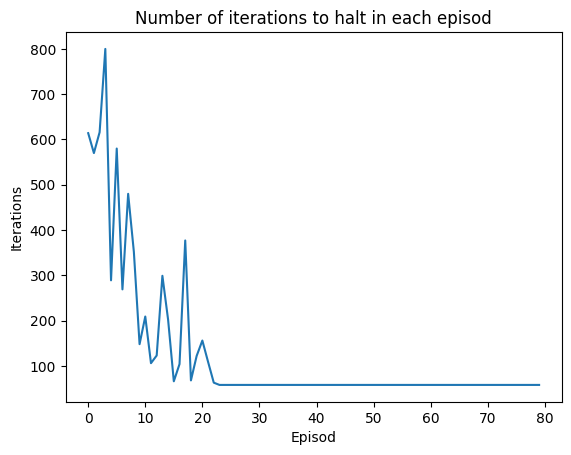

In [26]:
game = Env(7, 9, 0.25, 0.2)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()

gamma = 0.5, alpha = 0.2

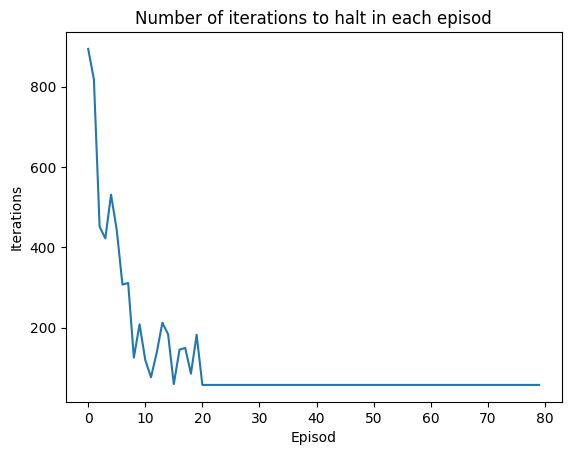

In [69]:
game = Env(7, 9, 0.5, 0.2)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

gamma = 1, alpha = 0.2

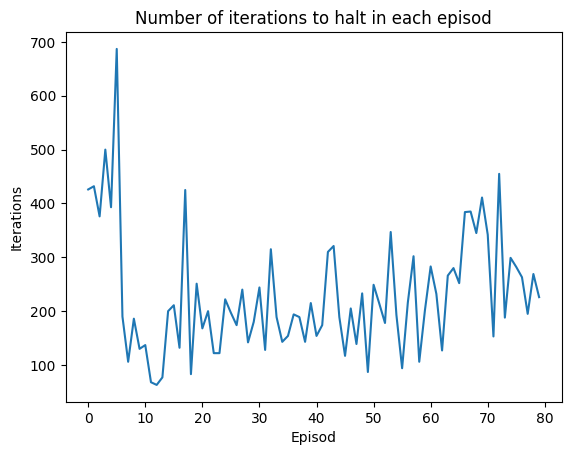

In [70]:
game = Env(7, 9, 1, 0.2)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

gamma = 0.25, alpha = 0.5

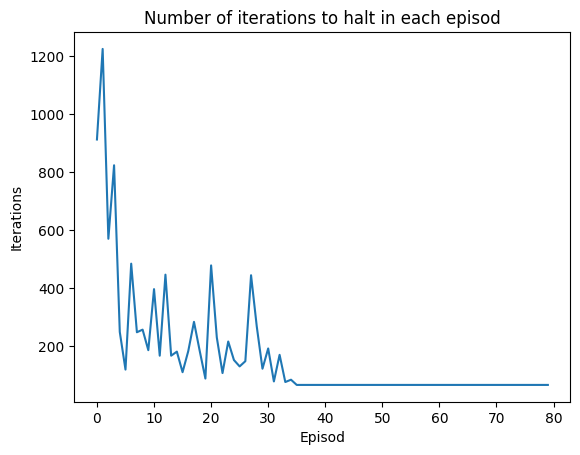

In [72]:
game = Env(7, 9, 0.25, 0.5)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

gamma = 0.5, alpha = 0.5

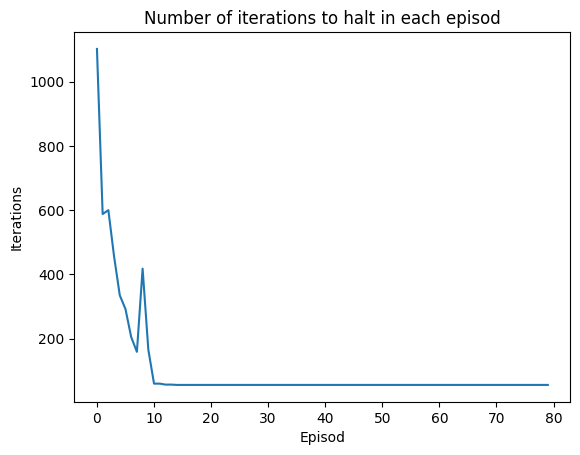

In [73]:
game = Env(7, 9, 0.5, 0.5)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

gamma = 1, alpha = 0.5

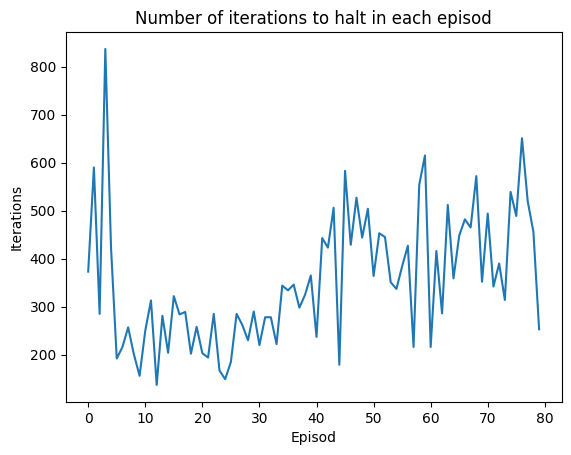

In [74]:
game = Env(7, 9, 1, 0.5)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

gamma = 0.25, alpha = 1

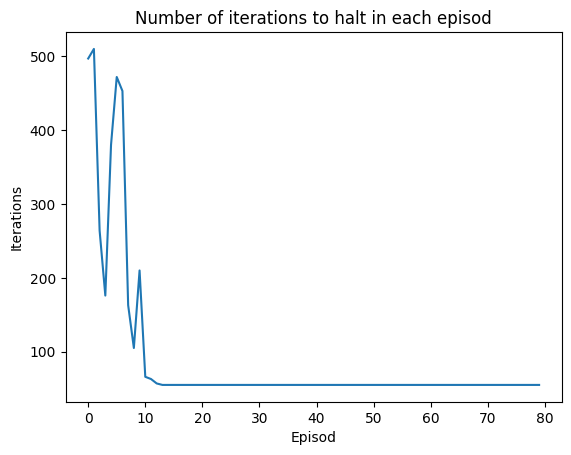

In [76]:
game = Env(7, 9, 0.25, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

gamma = 0.5, alpha = 1

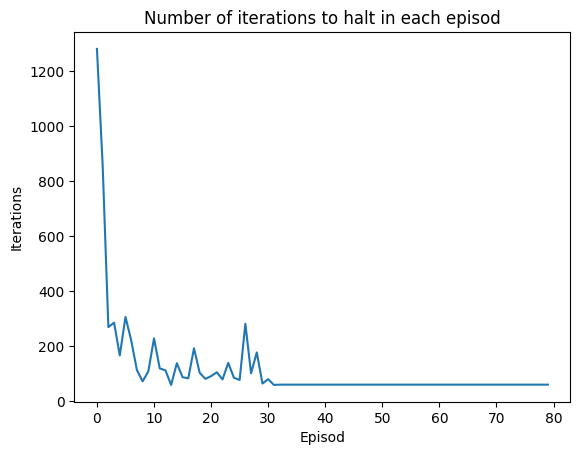

In [77]:
game = Env(7, 9, 0.5, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

gamma = 1, alpha = 1

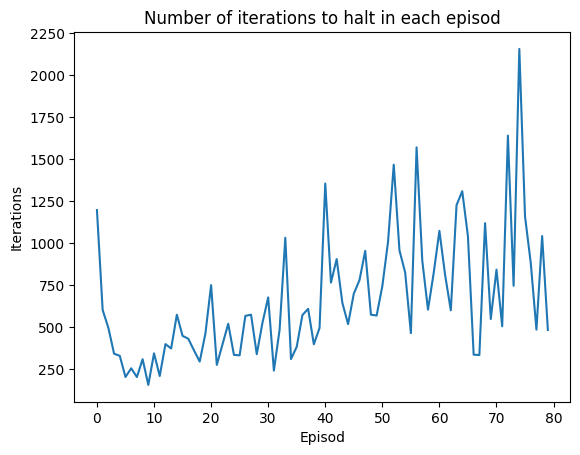

In [78]:
game = Env(7, 9, 1, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
#game.test_game()

### Configure Game using Map2

gamma = 0.25, alpha = 0.25

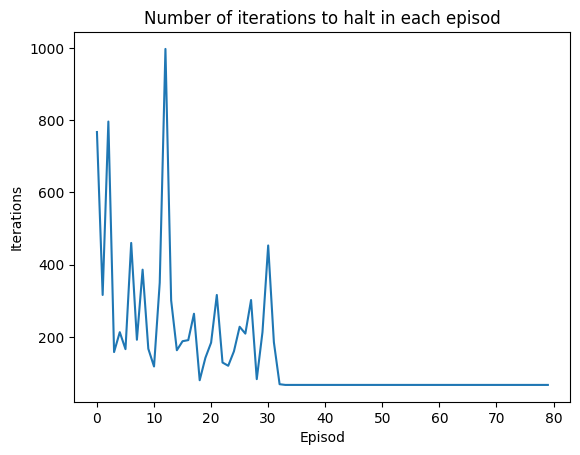

In [79]:
game = Env(7, 9, 0.25, 0.25)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 0.5, alpha = 0.25

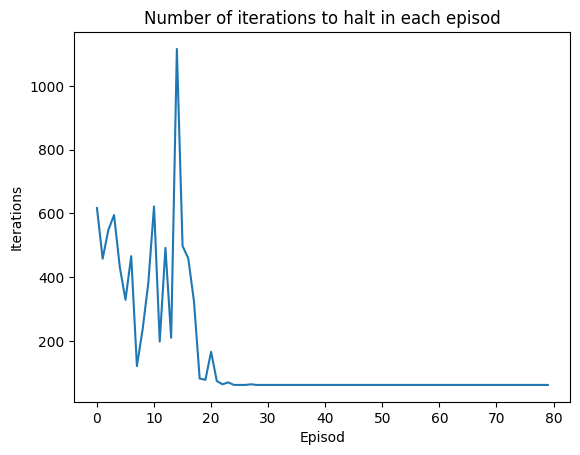

In [80]:
game = Env(7, 9, 0.5, 0.25)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 1, alpha = 0.25

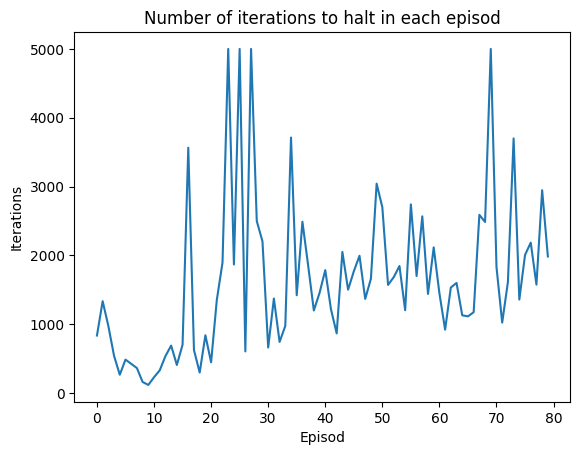

In [81]:
game = Env(7, 9, 1, 0.25)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 0.25, alpha = 0.5

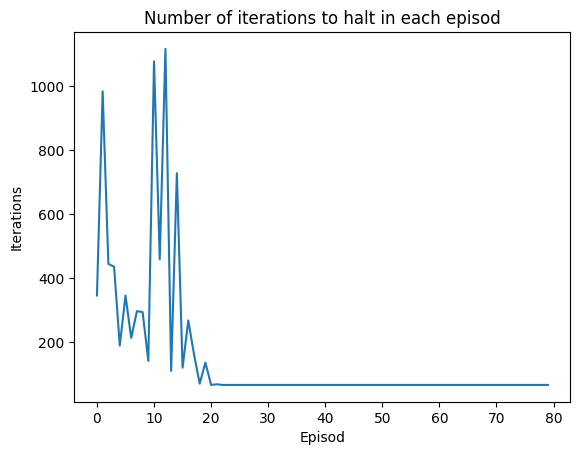

In [82]:
game = Env(7, 9, 0.25, 0.5)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 0.5, alpha = 0.5

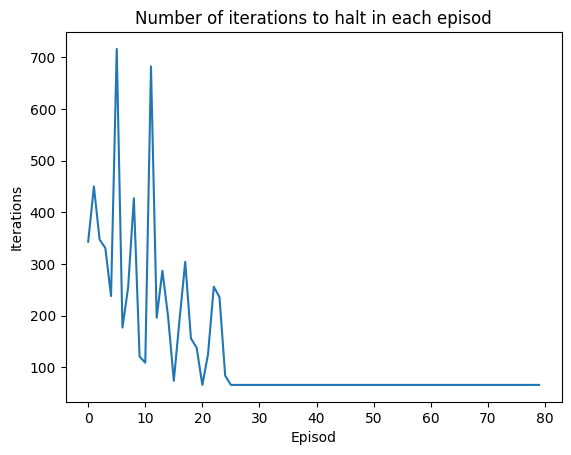

In [83]:
game = Env(7, 9, 0.5, 0.5)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 1, alpha = 0.5

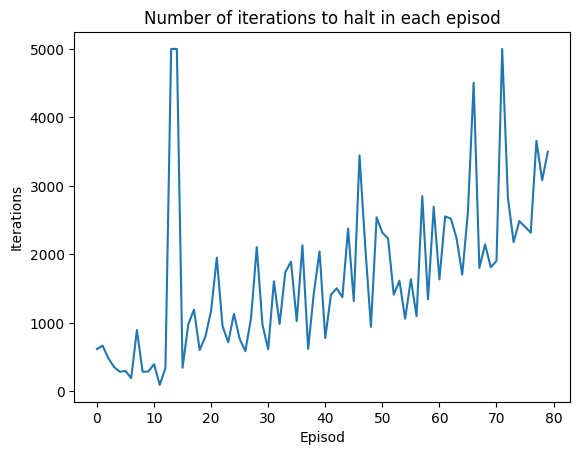

In [85]:
game = Env(7, 9, 1, 0.5)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 0.25, alpha = 1

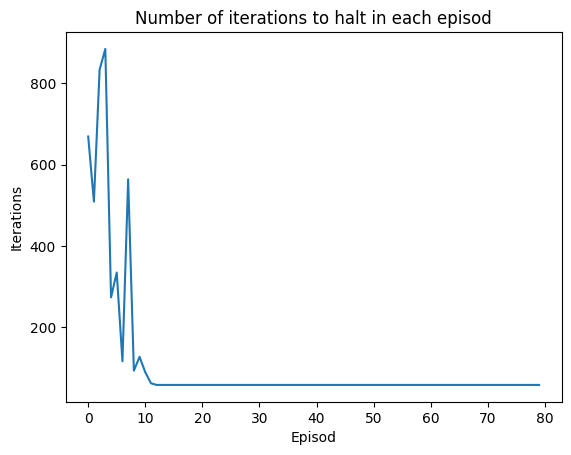

In [86]:
game = Env(7, 9, .25, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 0.5, alpha = 1

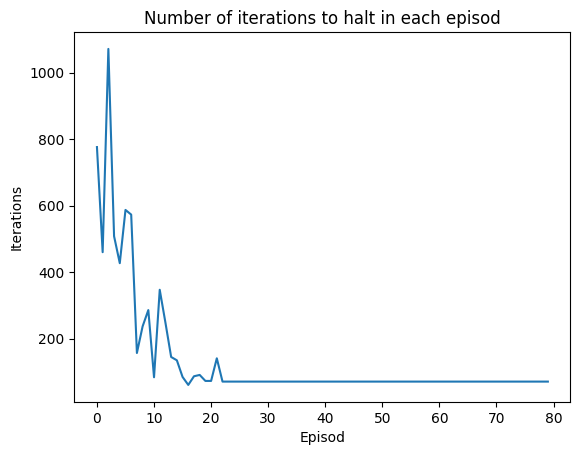

In [88]:
game = Env(7, 9, .5, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

gamma = 1, alpha = 1

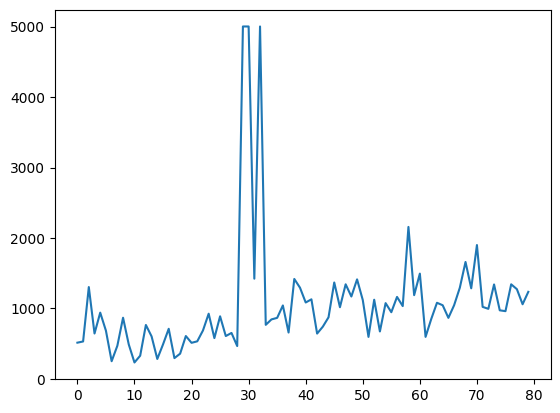

In [61]:
game = Env(7, 9, 1, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()

### Result:
As it is shown, if gamma is equal to 1, for any value of alpha, number of iterations do not converge to a particular number. But for gamma equal 0.25 and 0.5, for any alpha, convergence occures on avarage in 20 episods, and number of iterations for converged episods is less than 100 iterations for all pairs of gamma and alpha.

### Question7:
### Test Game for gamma=0.25 and alpha=1 on Map1 And Visualize It

In [ ]:
game = Env(7, 9, 0.25, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [2, 1], [4, 1], [5, 1], [3, 3], [4, 3], [5, 4], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [2, 7], [4, 7], [5, 7]]))
game.game()
game.test_game()

### Test Game for gamma=0.25 and alpha=1 on Map2 And Visualize It

In [ ]:
game = Env(7, 9, .5, 1)
game.add_wall(np.array([[1, 1], [1, 2], [1, 3], [1, 4], [4, 1], [5, 1], [2, 5], [4, 5], [3, 5], [1, 5], [1, 6], [1, 7], [5, 5]]))
game.game()
game.test_game()